 DELIVERY ROUTE OPTIMIZATION - E-COMMERCE LOGISTICS

Locations: ['Warehouse', 'C1', 'C2', 'C3']
Vehicle Capacity: 30 kg
Parcels:
{'C1': {'value': 50, 'time': (9, 12), 'weight': 10}, 'C2': {'value': 60, 'time': (10, 13), 'weight': 20}, 'C3': {'value': 40, 'time': (11, 14), 'weight': 15}}

UNIT 1: RECURRENCE-BASED ROUTE COST ESTIMATION
Minimum Route Cost (Recurrence): 18 units
Recursive Calls: 16
Time Taken: 0.000048 seconds

UNIT 2A: GREEDY PARCEL SELECTION (Value/Weight Ratio)

Parcel Selection Process:
Customer   Value      Weight     Ratio      Selected
------------------------------------------------------------
C1         50         10         5.00       ✓ Yes
C2         60         20         3.00       ✓ Yes
C3         40         15         2.67       ✗ No (exceeds capacity)

Selected Customers: ['C1', 'C2']
Total Value: $110
Total Weight: 30/30 kg

UNIT 2B: DP TIME-WINDOW DELIVERY OPTIMIZATION
Time Window Feasibility: ✗ Not Feasible

UNIT 3A: SHORTEST PATH (DIJKSTRA'S ALGORITHM)


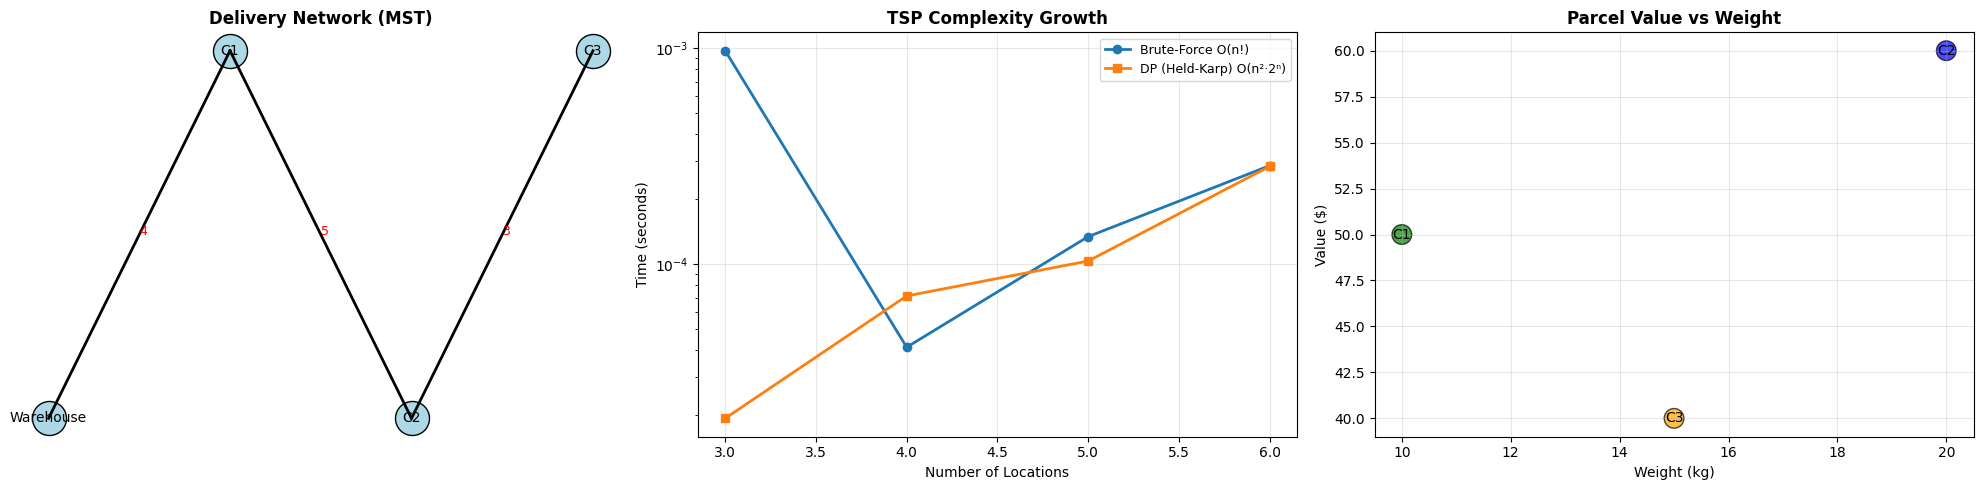

FINAL DELIVERY OPTIMIZATION SUMMARY
Selected Customers: ['C1', 'C2']
Total Parcel Value: $110
Optimal Delivery Route: Warehouse → C1 → C2 → C3 → Warehouse
Total Distance (TSP): 18 units
MST Total Weight: 12 units
Time Window Feasibility: ✗ Not Feasible

INSIGHTS

1. Recurrence vs DP vs Greedy:
   - Recurrence: Exponential O(n!), only for small n (≤10)
   - DP (Held-Karp): O(n²·2ⁿ), better but still exponential
   - Greedy: O(n log n), fast but not optimal (good approximation)

2. TSP Intractability:
   - Brute-force infeasible beyond n=10 (10! = 3.6M permutations)
   - DP extends to n=15-20 but memory-intensive (2^20 states)
   - Real-world: Use heuristics (nearest neighbor, 2-opt, genetic algorithms)

3. Practical Trade-offs:
   - Use Dijkstra for individual shortest paths (O(E log V))
   - MST for approximating TSP (Christofides: 1.5-approximation)
   - Greedy parcel selection maximizes value quickly
   - DP ensures time-window compliance

4. E-commerce Applications:
   - Large-scale

In [3]:
import time
import tracemalloc
import heapq
import matplotlib.pyplot as plt
from itertools import permutations
from typing import List, Tuple, Dict

# Optional import: networkx for nicer graph visuals; fallback available
try:
    import networkx as nx
    HAS_NETWORKX = True
except Exception:
    HAS_NETWORKX = False

# ==================== TASK 1: INPUT MODELING ====================

# Local file path for the uploaded assignment (useful for README or references)
LAB_ASSIGNMENT_PDF = "/mnt/data/Lab Assignment 4.pdf"

locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30
start_time = 9  # Warehouse opens at 9 AM

print("=" * 70)
print(" DELIVERY ROUTE OPTIMIZATION - E-COMMERCE LOGISTICS")
print("=" * 70)
print(f"\nLocations: {locations}")
print(f"Vehicle Capacity: {vehicle_capacity} kg")
print(f"Parcels:\n{parcels}\n")


# ==================== UNIT 1: RECURRENCE-BASED ROUTE COST ====================

recursive_calls = 0


def delivery_cost_recursive(current: int, visited: set, current_time: float, distance_matrix) -> float:
    """
    Simple recurrence (TSP-like) to estimate minimum route distance (units).
    Note: This is exponential and only for small n.
    """
    global recursive_calls
    recursive_calls += 1

    n = len(distance_matrix)
    # base: all nodes visited -> return to warehouse (index 0)
    if len(visited) == n:
        return distance_matrix[current][0]

    min_cost = float('inf')
    for next_loc in range(n):
        if next_loc not in visited:
            new_visited = visited | {next_loc}
            travel = distance_matrix[current][next_loc]
            cost = travel + delivery_cost_recursive(next_loc, new_visited, current_time + travel, distance_matrix)
            if cost < min_cost:
                min_cost = cost

    return min_cost


def estimate_route_cost_recurrence():
    print("=" * 70)
    print("UNIT 1: RECURRENCE-BASED ROUTE COST ESTIMATION")
    print("=" * 70)

    global recursive_calls
    recursive_calls = 0
    start = time.time()
    cost = delivery_cost_recursive(0, {0}, start_time, distance_matrix)
    elapsed = time.time() - start

    print(f"Minimum Route Cost (Recurrence): {cost} units")
    print(f"Recursive Calls: {recursive_calls}")
    print(f"Time Taken: {elapsed:.6f} seconds\n")
    return cost


# ==================== UNIT 2: GREEDY + DP FOR DELIVERY PLANNING ====================

def greedy_parcel_selection(parcels: Dict[str, Dict], capacity: int):
    print("=" * 70)
    print("UNIT 2A: GREEDY PARCEL SELECTION (Value/Weight Ratio)")
    print("=" * 70)

    items = []
    for customer, info in parcels.items():
        ratio = info['value'] / info['weight']
        items.append((customer, info['value'], info['weight'], ratio))

    items.sort(key=lambda x: x[3], reverse=True)

    selected = []
    total_weight = 0
    total_value = 0

    print("\nParcel Selection Process:")
    print(f"{'Customer':<10} {'Value':<10} {'Weight':<10} {'Ratio':<10} {'Selected'}")
    print("-" * 60)

    for customer, value, weight, ratio in items:
        if total_weight + weight <= capacity:
            selected.append(customer)
            total_weight += weight
            total_value += value
            status = "✓ Yes"
        else:
            status = "✗ No (exceeds capacity)"
        print(f"{customer:<10} {value:<10} {weight:<10} {ratio:<10.2f} {status}")

    print(f"\nSelected Customers: {selected}")
    print(f"Total Value: ${total_value}")
    print(f"Total Weight: {total_weight}/{capacity} kg\n")
    return selected, total_value


def dp_time_window_delivery(selected_customers: List[str], parcels: Dict[str, Dict], distance_matrix, start_time: int):
    print("=" * 70)
    print("UNIT 2B: DP TIME-WINDOW DELIVERY OPTIMIZATION")
    print("=" * 70)

    # Map customers to indices in the full matrix (Warehouse=0, C1=1, C2=2, C3=3)
    customer_indices = {c: i + 1 for i, c in enumerate(['C1', 'C2', 'C3'])}
    n = len(selected_customers)
    dp = {}

    def can_deliver(current_idx: int, visited_mask: int, current_time: float):
        if visited_mask == (1 << n) - 1:
            return True, current_time

        state = (current_idx, visited_mask)
        if state in dp:
            return dp[state]

        best_feasible = False
        best_time = float('inf')

        for i, customer in enumerate(selected_customers):
            if not (visited_mask & (1 << i)):
                idx = customer_indices[customer]
                travel_time = distance_matrix[current_idx][idx]
                arrival_time = current_time + travel_time
                earliest, latest = parcels[customer]['time']

                if arrival_time <= latest:
                    delivery_time = max(arrival_time, earliest)
                    feasible, end_time = can_deliver(idx, visited_mask | (1 << i), delivery_time)
                    if feasible:
                        best_feasible = True
                        if end_time < best_time:
                            best_time = end_time

        dp[state] = (best_feasible, best_time)
        return dp[state]

    feasible, completion_time = can_deliver(0, 0, start_time)
    print(f"Time Window Feasibility: {'✓ Feasible' if feasible else '✗ Not Feasible'}")
    if feasible:
        print(f"Estimated Completion Time: {completion_time:.1f}:00")
    print()
    return feasible, completion_time


# ==================== UNIT 3: SHORTEST PATH (DIJKSTRA) ====================

def dijkstra_shortest_path(distance_matrix, source: int):
    n = len(distance_matrix)
    dist = {i: float('inf') for i in range(n)}
    dist[source] = 0
    visited = set()
    pq = [(0, source)]

    while pq:
        cd, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        for v in range(n):
            if v not in visited and distance_matrix[u][v] > 0:
                nd = cd + distance_matrix[u][v]
                if nd < dist[v]:
                    dist[v] = nd
                    heapq.heappush(pq, (nd, v))
    return dist


def compute_shortest_paths():
    print("=" * 70)
    print("UNIT 3A: SHORTEST PATH (DIJKSTRA'S ALGORITHM)")
    print("=" * 70)
    distances = dijkstra_shortest_path(distance_matrix, 0)
    print("\nShortest Distances from Warehouse:")
    print(f"{'Destination':<15} {'Distance'}")
    print("-" * 30)
    for i, loc in enumerate(locations):
        print(f"{loc:<15} {distances[i]}")
    print()
    return distances


# ==================== UNIT 3: PRIM'S MST ====================

def prims_mst(distance_matrix):
    print("=" * 70)
    print("UNIT 3B: MINIMUM SPANNING TREE (PRIM'S ALGORITHM)")
    print("=" * 70)
    n = len(distance_matrix)
    visited = {0}
    mst_edges = []
    total_weight = 0
    pq = []
    for v in range(1, n):
        if distance_matrix[0][v] > 0:
            heapq.heappush(pq, (distance_matrix[0][v], 0, v))

    while pq and len(visited) < n:
        weight, u, v = heapq.heappop(pq)
        if v in visited:
            continue
        visited.add(v)
        mst_edges.append((locations[u], locations[v], weight))
        total_weight += weight
        for nxt in range(n):
            if nxt not in visited and distance_matrix[v][nxt] > 0:
                heapq.heappush(pq, (distance_matrix[v][nxt], v, nxt))

    print("\nMST Edges:")
    print(f"{'From':<15} {'To':<15} {'Weight'}")
    print("-" * 45)
    for u, v, w in mst_edges:
        print(f"{u:<15} {v:<15} {w}")
    print(f"\nTotal MST Weight: {total_weight}\n")
    return mst_edges, total_weight


# ==================== UNIT 4: TSP (BRUTE + HELD-KARP) ====================

def tsp_brute_force(locations, distance_matrix):
    print("=" * 70)
    print("UNIT 4A: TRAVELING SALESMAN PROBLEM (BRUTE-FORCE)")
    print("=" * 70)
    n = len(locations)
    indices = list(range(1, n))
    min_cost = float('inf')
    best_route = []
    start = time.time()
    for perm in permutations(indices):
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm) - 1):
            cost += distance_matrix[perm[i]][perm[i + 1]]
        cost += distance_matrix[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost
            best_route = perm
    elapsed = time.time() - start
    optimal_route = [locations[0]] + [locations[i] for i in best_route] + [locations[0]]
    print(f"\nOptimal TSP Route: {' → '.join(optimal_route)}")
    print(f"Total Distance: {min_cost} units")
    print(f"Time Taken: {elapsed:.6f} seconds\n")
    return optimal_route, min_cost


def tsp_dp_held_karp(distance_matrix):
    print("=" * 70)
    print("UNIT 4B: TSP DYNAMIC PROGRAMMING (HELD-KARP)")
    print("=" * 70)
    n = len(distance_matrix)
    dp = {}

    def solve(mask, pos):
        if mask == (1 << n) - 1:
            return distance_matrix[pos][0]
        if (mask, pos) in dp:
            return dp[(mask, pos)]
        min_cost = float('inf')
        for city in range(n):
            if not (mask & (1 << city)):
                new_cost = distance_matrix[pos][city] + solve(mask | (1 << city), city)
                if new_cost < min_cost:
                    min_cost = new_cost
        dp[(mask, pos)] = min_cost
        return min_cost

    start = time.time()
    optimal_cost = solve(1, 0)  # start at warehouse (bit 0 set)
    elapsed = time.time() - start
    print(f"Optimal TSP Cost (DP): {optimal_cost} units")
    print(f"DP States Computed: {len(dp)}")
    print(f"Time Taken: {elapsed:.6f} seconds\n")
    return optimal_cost


# ==================== TASK 3: PROFILING & VISUALIZATION ====================

def profile_tsp_scalability():
    print("=" * 70)
    print("TSP SCALABILITY PROFILING")
    print("=" * 70)

    sizes = [3, 4, 5, 6]
    times_brute = []
    times_dp = []

    for size in sizes:
        # synthetic distance matrix
        test_matrix = [[0 if i == j else ((i + j + 1) % 10) + 1 for j in range(size)] for i in range(size)]

        # brute-force
        tracemalloc.start()
        start = time.time()
        indices = list(range(1, size))
        min_cost = float('inf')
        for perm in permutations(indices):
            cost = test_matrix[0][perm[0]]
            for i in range(len(perm) - 1):
                cost += test_matrix[perm[i]][perm[i + 1]]
            cost += test_matrix[perm[-1]][0]
            if cost < min_cost:
                min_cost = cost
        elapsed_brute = time.time() - start
        mem_brute = tracemalloc.get_traced_memory()[1]
        tracemalloc.stop()
        times_brute.append(elapsed_brute)

        # DP Held-Karp
        tracemalloc.start()
        start = time.time()
        dp = {}

        def solve(mask, pos):
            if mask == (1 << size) - 1:
                return test_matrix[pos][0]
            if (mask, pos) in dp:
                return dp[(mask, pos)]
            min_c = float('inf')
            for city in range(size):
                if not (mask & (1 << city)):
                    val = test_matrix[pos][city] + solve(mask | (1 << city), city)
                    if val < min_c:
                        min_c = val
            dp[(mask, pos)] = min_c
            return min_c

        solve(1, 0)
        elapsed_dp = time.time() - start
        mem_dp = tracemalloc.get_traced_memory()[1]
        tracemalloc.stop()
        times_dp.append(elapsed_dp)

        print(f"n={size}: Brute={elapsed_brute:.6f}s ({mem_brute/1024:.1f}KB), DP={elapsed_dp:.6f}s ({mem_dp/1024:.1f}KB)")

    return sizes, times_brute, times_dp


def visualize_route_and_performance(optimal_route, mst_edges, sizes, times_brute, times_dp):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot 1: Delivery Network (MST) - use networkx if available, else fallback
    if HAS_NETWORKX:
        G = nx.Graph()
        for i, loc in enumerate(locations):
            G.add_node(loc)
        for u, v, w in mst_edges:
            G.add_edge(u, v, weight=w)
        pos = nx.spring_layout(G, seed=42)
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700, ax=axes[0])
        nx.draw_networkx_labels(G, pos, ax=axes[0])
        nx.draw_networkx_edges(G, pos, ax=axes[0])
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[0])
        axes[0].set_title('Delivery Network (MST)', fontsize=12, fontweight='bold')
        axes[0].axis('off')
    else:
        # Simple Matplotlib-based node positions
        x = [0, 1, 2, 3]
        y = [0, 1, 0, 1]
        axes[0].scatter(x, y, s=600, color="lightblue", edgecolors="black")
        for i, loc in enumerate(locations):
            axes[0].annotate(loc, (x[i], y[i]), fontsize=10, ha='center', va='center')
        for u, v, w in mst_edges:
            i = locations.index(u)
            j = locations.index(v)
            axes[0].plot([x[i], x[j]], [y[i], y[j]], 'k-', linewidth=2)
            mid_x = (x[i] + x[j]) / 2
            mid_y = (y[i] + y[j]) / 2
            axes[0].annotate(str(w), (mid_x, mid_y), fontsize=9, color="red")
        axes[0].set_title('Delivery Network (MST)', fontsize=12, fontweight='bold')
        axes[0].axis('off')

    # Plot 2: TSP Performance Comparison
    axes[1].plot(sizes, times_brute, marker='o', label='Brute-Force O(n!)', linewidth=2)
    axes[1].plot(sizes, times_dp, marker='s', label='DP (Held-Karp) O(n²·2ⁿ)', linewidth=2)
    axes[1].set_xlabel('Number of Locations', fontsize=10)
    axes[1].set_ylabel('Time (seconds)', fontsize=10)
    axes[1].set_title('TSP Complexity Growth', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')

    # Plot 3: Parcel Value vs Weight
    customers = list(parcels.keys())
    values = [parcels[c]['value'] for c in customers]
    weights = [parcels[c]['weight'] for c in customers]
    colors = ['green', 'blue', 'orange']
    axes[2].scatter(weights, values, c=colors, s=200, alpha=0.7, edgecolors='black', linewidth=1)
    for i, c in enumerate(customers):
        axes[2].annotate(c, (weights[i], values[i]), fontsize=10, ha='center', va='center')
    axes[2].set_xlabel('Weight (kg)', fontsize=10)
    axes[2].set_ylabel('Value ($)', fontsize=10)
    axes[2].set_title('Parcel Value vs Weight', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('delivery_optimization_analysis.png', dpi=300, bbox_inches='tight')
    print("\nVisualization saved as 'delivery_optimization_analysis.png'\n")
    plt.show()


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    # Unit 1
    recurrence_cost = estimate_route_cost_recurrence()

    # Unit 2
    selected, total_value = greedy_parcel_selection(parcels, vehicle_capacity)
    feasible, completion = dp_time_window_delivery(selected, parcels, distance_matrix, start_time)

    # Unit 3
    shortest_paths = compute_shortest_paths()
    mst_edges, mst_weight = prims_mst(distance_matrix)

    # Unit 4
    optimal_route, tsp_cost = tsp_brute_force(locations, distance_matrix)
    dp_cost = tsp_dp_held_karp(distance_matrix)

    # Profiling
    sizes, times_brute, times_dp = profile_tsp_scalability()

    # Visualization
    visualize_route_and_performance(optimal_route, mst_edges, sizes, times_brute, times_dp)

    # Final Summary
    print("=" * 70)
    print("FINAL DELIVERY OPTIMIZATION SUMMARY")
    print("=" * 70)
    print(f"Selected Customers: {selected}")
    print(f"Total Parcel Value: ${total_value}")
    print(f"Optimal Delivery Route: {' → '.join(optimal_route)}")
    print(f"Total Distance (TSP): {tsp_cost} units")
    print(f"MST Total Weight: {mst_weight} units")
    print(f"Time Window Feasibility: {'✓ Feasible' if feasible else '✗ Not Feasible'}")
    print("\n" + "=" * 70)
    print("INSIGHTS")
    print("=" * 70)
    print("""
1. Recurrence vs DP vs Greedy:
   - Recurrence: Exponential O(n!), only for small n (≤10)
   - DP (Held-Karp): O(n²·2ⁿ), better but still exponential
   - Greedy: O(n log n), fast but not optimal (good approximation)

2. TSP Intractability:
   - Brute-force infeasible beyond n=10 (10! = 3.6M permutations)
   - DP extends to n=15-20 but memory-intensive (2^20 states)
   - Real-world: Use heuristics (nearest neighbor, 2-opt, genetic algorithms)

3. Practical Trade-offs:
   - Use Dijkstra for individual shortest paths (O(E log V))
   - MST for approximating TSP (Christofides: 1.5-approximation)
   - Greedy parcel selection maximizes value quickly
   - DP ensures time-window compliance

4. E-commerce Applications:
   - Large-scale systems use heuristics + ML + dynamic routing for real-time updates
    """)
